In [1]:
import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt

In [2]:
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

available = []
pool=[]

#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True
            
####### normalise the count rates! think about the effect of 0-1 normalisation on the distance calculation
            
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))
    
lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])
lc_classes

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu, classes_abu, ids_abu, test_size=0.5, random_state=0, stratify=classes_abu)

In [209]:
from sklearn.cluster import KMeans
# training and test time series, both time[0] and count rate[1]
train_ts=x_train[0]
test_ts=x_train[0]

#segmentation of the ts
def segmentation(ts, seg_len, seg_slide, time_stamps=True):
    """ts=time series, seg_len=size of the moving window, seg_slide=difference in the starting position of the consecutive windows"""
    segments=[]
    if time_stamps=True:
        for start in range(0, len(ts[0])-seg_len, seg_slide):
            end=start+seg_len
            if ts[0][end]-ts[0][start] != seg_len: ####don't allow segments with missing data
                continue
            segments.append(np.copy(ts[:,start:end]))
        return segments
    else:
        for start in range(0, len(ts[0])-seg_len, seg_slide):
            end=start+seg_len
            if ts[0][end]-ts[0][start] != seg_len: ####don't allow segments with missing data
                continue
            segments.append(np.copy(ts[1][start:end]))
        return segments

#multiplication of the segments by a waveform to emphesise the features in the centre and zero the ends so that the segments can be joined smoothely together
def center_offset(segments, time_stamps=True, offset=True):
    window_rads = np.linspace(0, np.pi, len(segments[0][0]))
    window_sin = np.sin(window_rads)**2
    c_segments=[]
    if time_stamps=True:
        if offset=True:
            for segment in segments:
                segment[1]*=window_sin
                segment[0]-=segment[0][0]
                c_segments.append(segment)
            return c_segments
        else:
            for segment in segments:
                segment[1]*=window_sin
                c_segments.append(segment)
            return c_segments
    else:
        for segment in segments:
            segment*=window_sin
            c_segments.append(segment)
        return c_segments

def reconstruct(test_segments, test_ts, kmeans_model):
    reco= np.zeros(np.shape(test_ts))
    centroids=kmeans_model.cluster_centers_
    for n_seg, segment in enumerate(test_segments):
        pred_centroid=cluster.predict(np.array(segment[1]).reshape(1, -1))[0]
        start=n_seg*seg_slide
        end=start+len(segment)
        interval=np.sum(time_gaps[start+correct:end+correct])
        if interval != len(segment):
            correct += seg_slide
            continue
        print(correct)
        reco[start+correct:end+correct]+=centroids[pred_centroid]
    print(correct)
    return reco

In [210]:
#train the model
train_segments=segmentation(train_ts, 50, 2)
c_train_segments=centering(train_segments)
cluster.fit(c_train_segments[:,1])

#test segments
test_segments, test_gaps = segmentation(test_ts, 50, 25)
c_test_segments=centering(test_segments)

#reconstruct the test time series
reco = reconstruct(c_test_segments, test_gaps, cluster)

ValueError: operands could not be broadcast together with shapes (2,50) (2,) 

array([[ 7.57494077e+07,  7.57494087e+07,  7.57494097e+07,
         7.57494107e+07,  7.57494117e+07,  7.57494127e+07,
         7.57494137e+07,  7.57494147e+07,  7.57494157e+07,
         7.57494167e+07,  7.57494177e+07,  7.57494187e+07,
         7.57494197e+07,  7.57494207e+07,  7.57494217e+07,
         7.57494227e+07,  7.57494237e+07,  7.57494247e+07,
         7.57494257e+07,  7.57494267e+07,  7.57494277e+07,
         7.57494287e+07,  7.57494297e+07,  7.57494307e+07,
         7.57494317e+07,  7.57494327e+07,  7.57494337e+07,
         7.57494347e+07,  7.57494357e+07,  7.57494367e+07,
         7.57494377e+07,  7.57494387e+07,  7.57494397e+07,
         7.57494407e+07,  7.57494417e+07,  7.57494427e+07,
         7.57494437e+07,  7.57494447e+07,  7.57494457e+07,
         7.57494467e+07,  7.57494477e+07,  7.57494487e+07,
         7.57494497e+07,  7.57494507e+07,  7.57494517e+07,
         7.57494527e+07,  7.57494537e+07,  7.57494547e+07,
         7.57494557e+07,  7.57494567e+07],
       [ 2.27

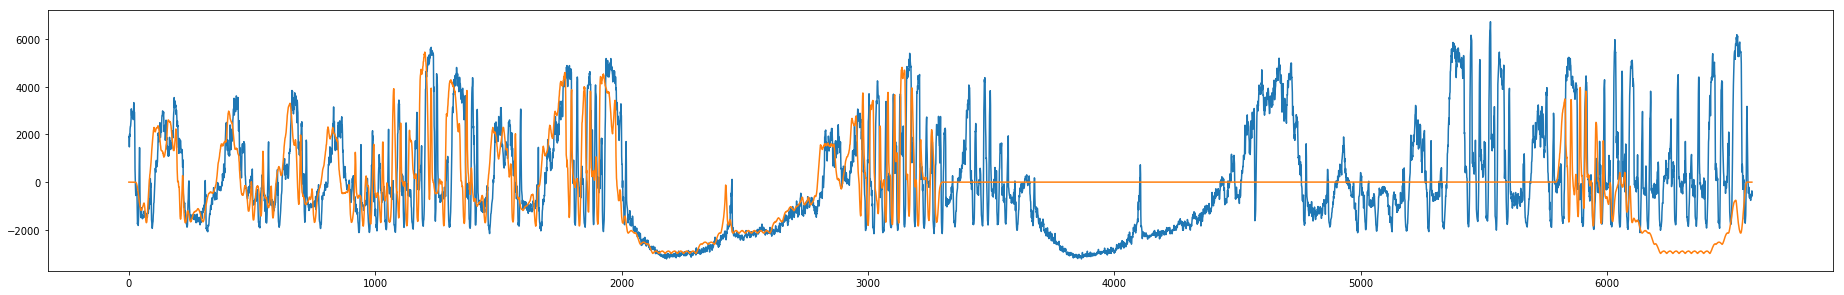

In [202]:
plt.figure(figsize=(6.4*5, 4.8))
plt.plot(test_ts[1])
plt.plot(reco)
plt.show()

In [171]:
test_gaps[22]
test_gaps[3315]


2491.5

In [3]:
seg_len=50
seg_slide=5
ts=x_train[0]
segments=[]
for start in range(0, len(ts[0])-seg_len, seg_slide):
    end=start+seg_len
    if ts[0][end]-ts[0][start] != seg_len:
        continue
    segments.append(np.copy(ts[1][start:end]))

In [4]:
window_rads = np.linspace(0, np.pi, seg_len)
window = np.sin(window_rads)**2
w_segments=[]
for segment in segments:
    w_segments.append(segment*window)

In [9]:
from sklearn.cluster import KMeans
cluster=KMeans(n_clusters=100, random_state=1).fit(w_segments)
centroids=cluster.cluster_centers_

In [30]:
seg_len=50
seg_slide=25
ts=x_train[49]
test_segments=[]
for start in range(0, len(ts[0])-seg_len, seg_slide):
    end=start+seg_len
    if ts[0][end]-ts[0][start] != seg_len:
        continue
    test_segments.append(np.copy(ts[1][start:end])*window)

In [37]:
prprpr=cluster.predict(np.array(test_segments[50]).reshape(1, -1))
#plt.plot(prprpr)
prprpr

29

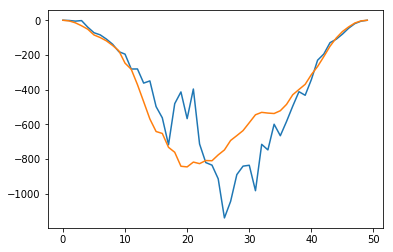

In [34]:
plt.plot(test_segments[50])
plt.plot(centroids[29])
plt.show()

In [100]:
np.where(np.array(id_train)=="10408-01-21-00")

(array([49]),)

In [97]:
reco= np.zeros(len(x_train[0][0]))
seg_len=50
seg_slide=25
ts=x_train[0]
test_segments=[]
for start in range(0, len(ts[0])-seg_len, seg_slide):
    end=start+seg_len
    if ts[0][end]-ts[0][start] != seg_len:
        continue
    test_segments.append(np.copy(ts[1][start:end])*window)

for n_seg, segment in enumerate(test_segments):
    pred_centroid=cluster.predict(np.array(segment).reshape(1, -1))[0]
    start=n_seg*seg_slide
    reco[start:start+len(segment)]+=centroids[pred_centroid]

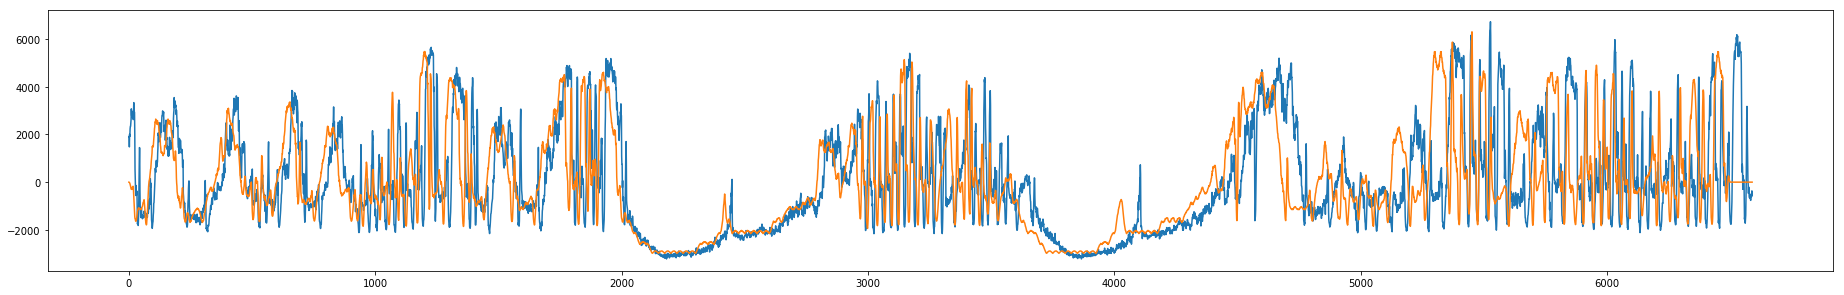

In [99]:
plt.figure(figsize=(6.4*5, 4.8))
plt.plot(x_train[0][1])
plt.plot(reco)
#plt.plot(np.abs(reco-x_train[49][1]))

plt.show()

In [50]:
np.abs(reco-x_train[49][1])

array([ 603.7794028 ,  730.12483294,  771.46573155, ..., 1269.2205972 ,
       1242.2205972 , 1264.2205972 ])